In [1]:
# 2018-2022년 전국 아파트 실거래 정보

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import openpyxl
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit

In [2]:

df1 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/complex_20230308 (사본).csv', header=None)
df1.columns = ['old_addr_idx', 'complex_name', 'property_type','시도','시군구',
               '읍면동','리','road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub','updated']
df1.drop(['road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub', 'updated'], axis=1, inplace=True)

df2 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/property_20230308.csv', header=None)
df2.columns = ['pk','old_addr_idx','dong','ho','official_price','net_leasable_area','updated']

df_tot = df2.merge(df1, on='old_addr_idx')

df_apt_tot = df_tot[df_tot['property_type']=='apartment']

pd.options.display.max_columns = None
df_apt_tot['평수'] = df_apt_tot['net_leasable_area'] / 3.3

ranges = [(0, 10, '10평 미만'), (10, 20, '10평대'), (20, 30, '20평대'), (30, 40, '30평대'), (40,50,'40평대'), (50,60,'50평대'),(60,200,'60평대 이상')]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

df_apt_tot['평형'] = pd.cut(df_apt_tot['평수'], bins=bins, labels=labels, include_lowest=True, right=False)
df_apt_tot.drop(['net_leasable_area'], axis=1, inplace=True)

df_apt_tot['시군구'] = df_apt_tot['시군구'].str.split().str[0]



df_apt_tot.reset_index(inplace=True)
df_apt_tot.replace('\\N', np.nan, inplace=True)
#df_apt_tot

/tmp/ipykernel_9942/1187988351.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apt_tot['평수'] = df_apt_tot['net_leasable_area'] / 3.3
/tmp/ipykernel_9942/1187988351.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apt_tot['평형'] = pd.cut(df_apt_tot['평수'], bins=bins, labels=labels, include_lowest=True, right=False)
/tmp/ipykernel_9942/1187988351.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.

In [3]:
df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv')

df3.columns = ['old_addr_idx', '거래날짜', '거래가격', '면적', '층수', '호수일지도', '거래방식', 'Unknown', '입주날짜일지도', 
                '시군구 엉망', '도로명으로 추정', '읍면동 real', '건물이름', '세대수일지도', '준공연도로 추정', '건물종류']
df3 = df3.drop_duplicates() 
df3.drop(['Unknown', '호수일지도', '입주날짜일지도', '세대수일지도', '준공연도로 추정'], axis=1, inplace=True)

df3['거래연도'] = df3['거래날짜'].str.split('-').str[0].astype(int)
df3['거래달'] = df3['거래날짜'].str.split('-').str[1].astype(int)


pd.options.display.max_columns = None
df3['평수 real'] = df3['면적'] / 3.3

ranges = [(0, 10, '10평 미만'), (10, 20, '10평대'), (20, 30, '20평대'), (30, 40, '30평대'), (40,50,'40평대'), (50,60,'50평대'),(60,300, '60평대 이상')]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

df3['평형 real'] = pd.cut(df3['평수 real'], bins=bins, labels=labels, include_lowest=True, right=False)
df3.drop(['면적'], axis=1, inplace=True)



df3.fillna("NONE", inplace=True)
# df3.loc[df3['건물종류'].str.contains('apartment'), '건물종류'] = 'apartment'
df3 = df3[~df3['건물종류'].str.contains('officetel')]
df3.drop(['거래날짜', '건물이름', '건물종류', '거래방식', '시군구 엉망', '도로명으로 추정', '읍면동 real'], axis=1, inplace=True)

#df3
# 실거래가 정보_아파트만

/tmp/ipykernel_9942/301706533.py:1: DtypeWarning: Columns (5,6,8,9,10,11,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('/home/subin/다운로드/여피/0315 업무/trade_history_2018-2023_edit.csv')


In [4]:
ranges = [(-5, 0, '지하'), (0, 6, '1-5층'), (6, 11, '6-10층'), (11, 16, '11-15층'), (16, 21, '16-20층'), (21,26,'21-25층'), (26,100,'26층 이상')]

labels = [r[2] for r in ranges]
bins = [r[0] for r in ranges] + [ranges[-1][1]]

df3['층 구분'] = pd.cut(df3['층수'], bins=bins, labels=labels, include_lowest=True, right=False)
df3

,old_addr_idx,거래가격,층수,거래연도,거래달,평수 real,평형 real,층 구분
0,3023010200_00027_00007_apartment,70000000,5,2020,2,17.048485,10평대,1-5층
1,3023010200_00027_00007_apartment,66000000,1,2020,3,17.048485,10평대,1-5층
2,3023010200_00027_00007_apartment,77000000,3,2020,4,17.048485,10평대,1-5층
3,3023010200_00027_00007_apartment,70000000,5,2020,5,17.048485,10평대,1-5층
4,3023010200_00027_00007_apartment,97500000,5,2020,8,17.048485,10평대,1-5층
...,...,...,...,...,...,...,...,...
2203362,5011010400_01034_00001_apartment,280000000,5,2022,9,25.436970,20평대,1-5층
2203363,5011010400_00777_00000_apartment,580000000,4,2022,9,12.027273,10평대,1-5층
2203364,5013010400_02161_00000_apartment,317000000,2,2022,9,25.704212,20평대,1-5층
2203365,5013010500_00147_00000_apartment,214000000,1,2022,9,12.027273,10평대,1-5층


In [5]:
df4 = pd.read_excel('/home/subin/다운로드/행정_법정동 중심좌표.xlsx')
df4 = df4[df4['코드종류']=='B']
df4.drop(['코드', '코드종류'], axis=1, inplace=True)
df4['리'] = df4['하위']
df4.drop(['하위'], axis=1, inplace=True)
#df4

In [6]:
match = df_apt_tot[['old_addr_idx', '시도', '시군구', '읍면동', '리']]
match = match.drop_duplicates()
#match

In [7]:
area_code = match.merge(df4, on=['시도', '시군구', '읍면동', '리'])
#area_code

In [8]:
korea = df3.merge(area_code, on='old_addr_idx')
korea['위도+경도'] = korea['위도'].astype(str) + korea['경도'].astype(str)
value_counts = korea['위도+경도'].value_counts()

# Map the value counts to a new column in the dataframe
korea['data'] = korea['위도+경도'].map(value_counts)
#korea

In [9]:
korea.drop([ '리', '위도+경도'], axis=1, inplace=True)

In [10]:
main = korea[(korea['시도']=='서울특별시')|(korea['시도']=='경기도')|(korea['시도']=='인천광역시')]
main

,old_addr_idx,거래가격,층수,거래연도,거래달,평수 real,평형 real,층 구분,시도,시군구,읍면동,위도,경도,data
404944,4182025023_00281_00000_apartment,105000000,10,2018,1,18.145455,10평대,6-10층,경기도,가평군,가평읍,37.810731,127.519890,77
404945,4182025023_00281_00000_apartment,105000000,10,2018,1,18.145455,10평대,6-10층,경기도,가평군,가평읍,37.810731,127.519890,77
404946,4182025023_00281_00000_apartment,107000000,15,2018,2,17.863636,10평대,11-15층,경기도,가평군,가평읍,37.810731,127.519890,77
404947,4182025023_00281_00000_apartment,94000000,3,2018,2,21.645455,20평대,1-5층,경기도,가평군,가평읍,37.810731,127.519890,77
404948,4182025023_00281_00000_apartment,163000000,4,2018,2,25.709091,20평대,1-5층,경기도,가평군,가평읍,37.810731,127.519890,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675283,1156011300_00563_00000_apartment,1005000000,7,2022,11,25.718515,20평대,6-10층,서울특별시,영등포구,당산동3가,37.525551,126.896668,336
1675284,1159010700_01159_00000_apartment,1500000000,8,2022,11,25.751515,20평대,6-10층,서울특별시,동작구,사당동,37.483974,126.974999,1879
1675285,1162010100_01560_00061_apartment,660000000,5,2022,11,25.724242,20평대,1-5층,서울특별시,관악구,봉천동,37.482717,126.949951,4867
1675286,1168010300_01282_00000_apartment,2400000000,33,2022,11,25.706061,20평대,26층 이상,서울특별시,강남구,개포동,37.478260,127.052024,471


In [11]:
main_name = main[['old_addr_idx', '위도', '경도']]
main_name = main_name.drop_duplicates()

In [12]:
school = pd.read_excel('/home/subin/다운로드/전국초중등학교위치표준데이터-20230404.xls')
school.rename(columns=school.iloc[0], inplace=True)
school = school.drop(0)

school['시도']=school['시도교육청명'].str.split('교육청').str[0]
school.drop(['시도교육청명', '제공기관명', '생성일자', '변경일자', '교육지원청명', '데이터기준일자','소재지지번주소', '소재지도로명주소', '설립일자',
             '학교ID', '제공기관코드', '시도교육청코드', '교육지원청코드', '운영상태'], axis=1, inplace=True)
school['학교급구분'] = school['학교급구분'].str.split('학교').str[0]

school['위도'] = school['위도'].astype(float).round(6)
school['경도'] = school['경도'].astype(float).round(6)

#school

In [13]:
school_main = school[(school['시도']=='서울특별시')|(school['시도']=='경기도')|(school['시도']=='인천광역시')]
school_main

,학교명,학교급구분,설립형태,본교분교구분,위도,경도,시도
7,하안중학교,중,공립,본교,37.467386,126.880772,경기도
8,현산중학교,중,공립,본교,37.691246,126.774003,경기도
9,은광여자고등학교,고등,사립,본교,37.488379,127.035232,서울특별시
12,숭덕여자고등학교,고등,사립,본교,37.464282,126.733917,인천광역시
13,산마을고등학교,고등,사립,본교,37.686363,126.425565,인천광역시
...,...,...,...,...,...,...,...
11975,서울문영여자고등학교,고등,사립,본교,37.472905,126.950918,서울특별시
11976,서울갈산초등학교,초등,공립,본교,37.512372,126.870230,서울특별시
11977,서울태랑초등학교,초등,공립,본교,37.628783,127.088992,서울특별시
11978,서울한천초등학교,초등,공립,본교,37.620709,127.069244,서울특별시


In [14]:
school_ele = school_main[school_main['학교급구분']=='초등']
school_mid = school_main[school_main['학교급구분']=='중']
school_high = school_main[school_main['학교급구분']=='고등']

In [15]:
school_main= school.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_ele = school_ele.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_mid = school_mid.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_high = school_high.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
#school_seoul_all

In [16]:
subway = pd.read_csv('/home/subin/다운로드/서울시 역사마스터 정보.csv',encoding='cp949')
subway_name = subway.drop(['역사_ID', '호선'], axis=1)
subway_name.drop_duplicates(inplace=True)
subway_name['환승역'] = 0  # set all values in the '환승역' column to 0 first
duplicates = subway_name['역사명'].duplicated()  # identify duplicated values in the '역사명' column
subway_name.loc[duplicates, '환승역'] = 1  # set the '환승역' column to 1 only for duplicated rows
subway_name = subway_name[subway_name['환승역'] != 1]
subway_name = subway_name.rename(columns={'위도': '경도', '경도': '위도'})

In [17]:
from scipy.spatial.distance import cdist

# Calculate the distance matrix between all pairs of housing and train stations using the Haversine formula
housing_coords = main_name[['위도', '경도']].values
train_station_coords = subway_name[['위도', '경도']].values
distances_matrix = cdist(housing_coords, train_station_coords, metric=haversine)

# Convert the distance matrix to a dataframe
distances_df = pd.DataFrame(distances_matrix, columns=subway_name['역사명'], index=main_name['old_addr_idx'])
distances_df = distances_df.reset_index().melt(id_vars='old_addr_idx', var_name='train_station_id', value_name='distance')

In [18]:
main_subway_1km =distances_df[distances_df['distance']<=1]
main_subway = pd.merge(main_name, main_subway_1km, how='left', on='old_addr_idx')

main_subway['train_station_id'] = main_subway['train_station_id'].replace('총신대입구', '이수')
main_subway.drop_duplicates(inplace=True)
value_counts2 = main_subway[main_subway['distance']<=1]['old_addr_idx'].value_counts()

In [19]:
# Map the value counts to a new column in the dataframe
main['지하철역 수'] = main['old_addr_idx'].map(value_counts2)
main['지하철역 수'] = main['지하철역 수'].fillna(0)
#main

/tmp/ipykernel_9942/1011622294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['지하철역 수'] = main['old_addr_idx'].map(value_counts2)
/tmp/ipykernel_9942/1011622294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['지하철역 수'] = main['지하철역 수'].fillna(0)


In [20]:
closest_subway_dis =distances_df.groupby('old_addr_idx').min().drop('train_station_id', axis=1).reset_index()
main = main.merge(closest_subway_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_sub'})

In [21]:
main_subway_30km = distances_df[distances_df['distance']<30]

In [47]:
main['sub_1km'] = (main['closest_sub'] < 1).astype(int)
main['sub_2km'] = (main['closest_sub'] < 2).astype(int)
main['sub_3km'] = (main['closest_sub'] < 3).astype(int)

In [24]:
housing_coords = main_name[['위도', '경도']].values
school_coords = school_main[['위도', '경도']].values
distances_matrix2 = cdist(housing_coords, school_coords, metric=haversine)

# Convert the distance matrix to a dataframe
distances_df2 = pd.DataFrame(distances_matrix2, columns=school_main['학교명'], index=main_name['old_addr_idx'])

# Melt the dataframe to a long format
distances_df2 = distances_df2.reset_index().melt(id_vars='old_addr_idx', var_name='school_id', value_name='distance')

# Drop duplicates and reset the index
distances_df2.drop_duplicates(inplace=True)
distances_df2.reset_index(drop=True, inplace=True)

In [25]:
main_school_10km =distances_df2[distances_df2['distance']<=10]

In [26]:
main_school_10km['school_id'] = main_school_10km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
main_school_10km['school_id'] = main_school_10km['school_id'].replace('동성고등공민학교', '동성공민고등학교')

/tmp/ipykernel_9942/1605587809.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_school_10km['school_id'] = main_school_10km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
/tmp/ipykernel_9942/1605587809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_school_10km['school_id'] = main_school_10km['school_id'].replace('동성고등공민학교', '동성공민고등학교')


In [27]:
main_ele_10km = main_school_10km[main_school_10km['school_id'].str.contains('초등학교')]
main_mid_10km = main_school_10km[main_school_10km['school_id'].str.contains('중학교')]
main_high_10km = main_school_10km[main_school_10km['school_id'].str.contains('고등학교')]

In [28]:
main_school_1km =main_school_10km[main_school_10km['distance']<=1]
main_school = pd.merge(main_name, main_school_1km, how='left', on='old_addr_idx')

In [29]:
value_counts2 = main_school[main_school['distance']<=1]['old_addr_idx'].value_counts()
main['school_1km'] = main['old_addr_idx'].map(value_counts2)
main['school_1km'] = main['school_1km'].fillna(0)
#main

In [30]:
closest_school_dis =main_school_10km.groupby('old_addr_idx').min().drop('school_id', axis=1).reset_index()
main = main.merge(closest_school_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_school'})

In [31]:
closest_ele_dis =main_ele_10km.groupby('old_addr_idx').min().drop('school_id', axis=1).reset_index()
main = main.merge(closest_ele_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_ele'})

In [32]:
closest_mid_dis =main_mid_10km.groupby('old_addr_idx').min().drop('school_id', axis=1).reset_index()
main = main.merge(closest_mid_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_mid'})

In [33]:
closest_high_dis =main_high_10km.groupby('old_addr_idx').min().drop('school_id', axis=1).reset_index()
main = main.merge(closest_high_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_high'})

In [36]:
main['school_1km'] = (main['closest_school'] < 1).astype(int)
main['ele_1km'] = (main['closest_ele'] < 1).astype(int)
main['mid_1km'] = (main['closest_mid'] < 1).astype(int)
main['high_1km'] = (main['closest_high'] < 1).astype(int)

In [43]:
main['school_2km'] = (main['closest_school'] < 2).astype(int)
main['ele_2km'] = (main['closest_ele'] < 2).astype(int)
main['mid_2km'] = (main['closest_mid'] < 2).astype(int)
main['high_2km'] = (main['closest_high'] < 2).astype(int)

In [44]:
main['school_3km'] = (main['closest_school'] < 3).astype(int)
main['ele_3km'] = (main['closest_ele'] < 3).astype(int)
main['mid_3km'] = (main['closest_mid'] < 3).astype(int)
main['high_3km'] = (main['closest_high'] < 3).astype(int)

In [45]:
main['school_4km'] = (main['closest_school'] < 4).astype(int)
main['ele_4km'] = (main['closest_ele'] < 4).astype(int)
main['mid_4km'] = (main['closest_mid'] < 4).astype(int)
main['high_4km'] = (main['closest_high'] < 4).astype(int)

In [46]:
main['school_5km'] = (main['closest_school'] < 5).astype(int)
main['ele_5km'] = (main['closest_ele'] < 5).astype(int)
main['mid_5km'] = (main['closest_mid'] < 5).astype(int)
main['high_5km'] = (main['closest_high'] < 5).astype(int)

In [34]:
area_map = {
    '10평 미만': 0,
    '10평대': 1,
    '20평대': 2,
    '30평대': 3,
    '40평대': 4,
    '50평대': 5,
    '60평대 이상': 6
}

floor_map = {
    '지하': 0,
    '1-5층': 1,
    '6-10층': 2,
    '11-15층': 3,
    '16-20층': 4,
    '21-25층': 5,
    '26층 이상': 6
}

# Map the categories to integer labels using the map() method and the appropriate dictionary for each column
main['area_encoded'] = main['평형 real'].map(area_map)
main['floor_encoded'] = main['층 구분'].map(floor_map)

In [35]:
main['scaled_floor'] = main.groupby('old_addr_idx')['층수'].rank(pct=True)

In [132]:
main_withPrice =main.drop(['old_addr_idx', '평형 real', '시도', '시군구', '읍면동', '거래연도', '거래달', 'data', '층 구분'], axis=1)
main_withPrice

,거래가격,층수,평수 real,위도,경도,지하철역 수,closest_sub,sub_1km,school_1km,closest_school,closest_ele,closest_mid,closest_high,area_encoded,floor_encoded,scaled_floor,ele_1km,mid_1km,high_1km,sub_2km,sub_3km,school_2km,ele_2km,mid_2km,high_2km,school_3km,ele_3km,mid_3km,high_3km,school_4km,ele_4km,mid_4km,high_4km,school_5km,ele_5km,mid_5km,high_5km
0,105000000,10,18.145455,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,1,2,0.540541,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,105000000,10,18.145455,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,1,2,0.540541,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
2,107000000,15,17.863636,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,1,3,0.702703,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,94000000,3,21.645455,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,2,1,0.162162,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
4,163000000,4,25.709091,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,2,1,0.216216,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713613,1005000000,7,25.718515,37.525551,126.896668,4.0,0.208407,1,1,0.639166,0.639166,0.657734,0.942312,2,2,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
713614,1500000000,8,25.751515,37.483974,126.974999,4.0,0.337862,1,1,0.081377,0.081377,0.594956,0.887895,2,2,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
713615,660000000,5,25.724242,37.482717,126.949951,2.0,0.295361,1,1,0.321724,0.321724,0.803749,0.787177,2,1,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
713616,2400000000,33,25.706061,37.478260,127.052024,0.0,1.071480,0,1,0.230795,0.264160,0.827661,0.230795,2,6,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [49]:
main_withoutPrice =main.drop(['old_addr_idx', '평형 real', '시도', '시군구', '읍면동', '거래연도', '거래달', 'data', '층 구분', '거래가격'], axis=1)
main_withoutPrice

,층수,평수 real,위도,경도,지하철역 수,closest_sub,sub_1km,school_1km,closest_school,closest_ele,closest_mid,closest_high,area_encoded,floor_encoded,scaled_floor,ele_1km,mid_1km,high_1km,sub_2km,sub_3km,school_2km,ele_2km,mid_2km,high_2km,school_3km,ele_3km,mid_3km,high_3km,school_4km,ele_4km,mid_4km,high_4km,school_5km,ele_5km,mid_5km,high_5km
0,10,18.145455,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,1,2,0.540541,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,10,18.145455,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,1,2,0.540541,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
2,15,17.863636,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,1,3,0.702703,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
3,3,21.645455,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,2,1,0.162162,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
4,4,25.709091,37.810731,127.519890,1.0,0.908426,1,0,1.030822,2.492239,2.059789,1.030822,2,1,0.216216,0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713613,7,25.718515,37.525551,126.896668,4.0,0.208407,1,1,0.639166,0.639166,0.657734,0.942312,2,2,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
713614,8,25.751515,37.483974,126.974999,4.0,0.337862,1,1,0.081377,0.081377,0.594956,0.887895,2,2,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
713615,5,25.724242,37.482717,126.949951,2.0,0.295361,1,1,0.321724,0.321724,0.803749,0.787177,2,1,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
713616,33,25.706061,37.478260,127.052024,0.0,1.071480,0,1,0.230795,0.264160,0.827661,0.230795,2,6,1.000000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


<Axes: title={'center': 'Correlation of Features'}>

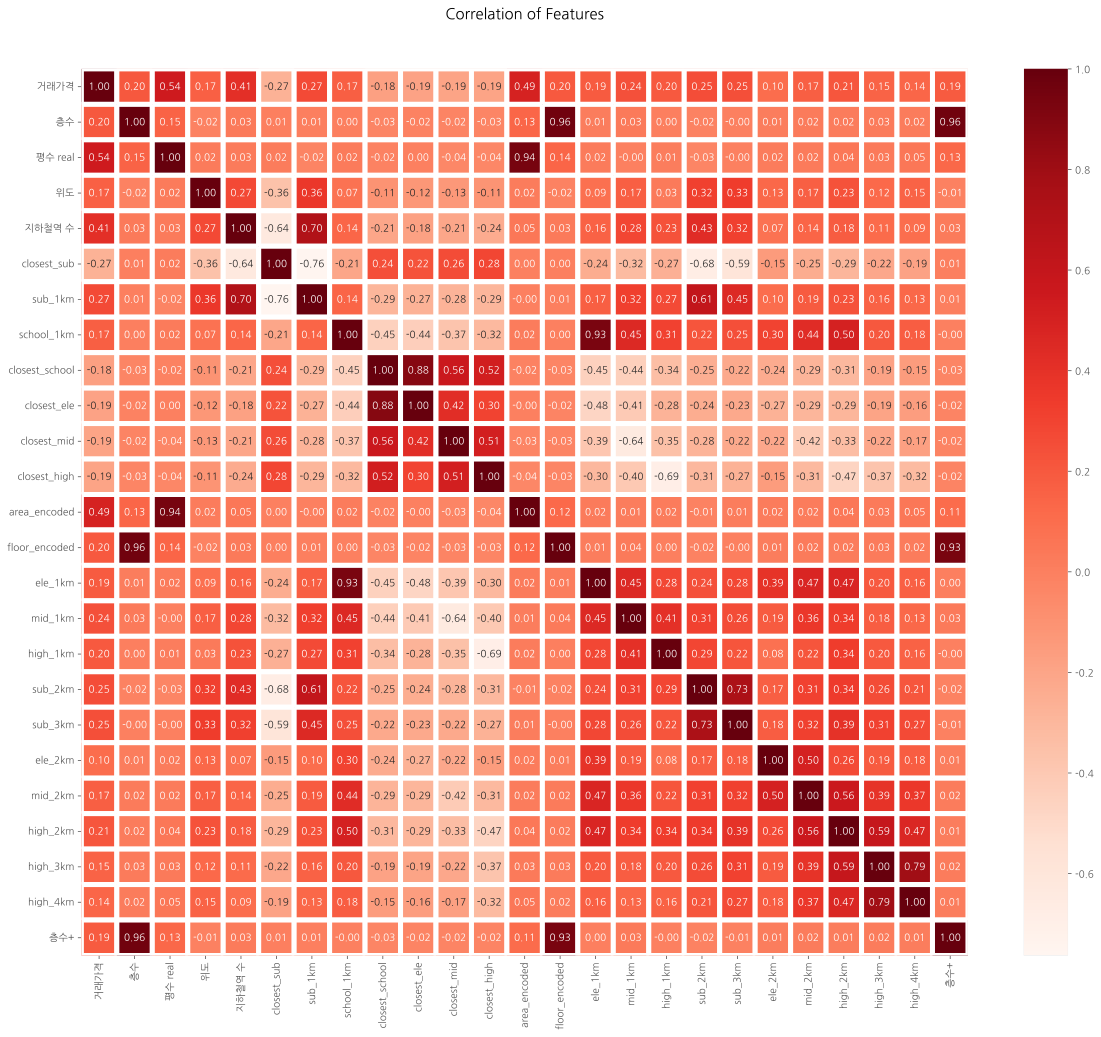

In [166]:
plt.figure(figsize=(20, 16))
plt.title("Correlation of Features", y = 1.05, size = 15)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)
sns.heatmap(scaled_features_df3.corr(),annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds')

In [ ]:
scaled_features_df3_feat = scaled_features_df3.drop(['ele_2km', 'high_4km', 'high_3km', 'mid_2km', ''],axis=1)

In [171]:
minmax_scaler=MinMaxScaler()
scaled_features=minmax_scaler.fit_transform(main_withPrice)
scaled_features2=minmax_scaler.fit_transform(main_withoutPrice)
scaled_features_df = pd.DataFrame(scaled_features, columns=main_withPrice.columns)
scaled_features_df2 = pd.DataFrame(scaled_features2, columns=main_withoutPrice.columns)
scaled_features3=minmax_scaler.fit_transform(main_withPrice_skew)
scaled_features_df3 = pd.DataFrame(scaled_features3, columns=main_withPrice_skew.columns)

In [178]:
corr = scaled_features_df3.corr()
#corr
corr['거래가격'].sort_values(ascending=False)

거래가격              1.000000
평수 real           0.541086
area_encoded      0.493101
지하철역 수            0.412845
sub_1km           0.267337
sub_2km           0.252342
sub_3km           0.248677
mid_1km           0.236443
high_2km          0.209469
층수                0.202748
floor_encoded     0.199180
high_1km          0.195807
ele_1km           0.191024
층수+               0.188859
mid_2km           0.172264
school_1km        0.168394
위도                0.166683
high_3km          0.146627
high_4km          0.137600
ele_2km           0.101454
경도                0.089076
closest_school   -0.176343
closest_ele      -0.187804
closest_mid      -0.193235
closest_high     -0.194055
closest_sub      -0.273531
Name: 거래가격, dtype: float64

In [174]:
scaled_features_df3.drop(['school_4km', 'ele_4km', 'school_5km', 'ele_5km', 'mid_3km', 'high_5km', 'school_2km', 'mid_4km'], axis=1, inplace=True)

In [177]:
scaled_features_df3.drop(['school_4km', 'ele_4km', 'school_5km', 'ele_5km', 'mid_3km', 'high_5km', 'school_2km', 'mid_4km'], axis=1, inplace=True)
scaled_features_df3.drop(['ele_3km', 'school_3km', 'mid_5km', 'scaled_floor'], axis=1, inplace=True)

In [160]:
scaled_features_df3_feat = scaled_features_df3.drop(['층수'],axis=1)

In [133]:
main_withPrice_skew = main_withPrice

In [186]:
main_withoutPrice_skew = main_withoutPrice
main_withoutPrice_skew['층수+'] = main_withoutPrice_skew['층수']+4
main_withoutPrice_skew[[ '층수+', '평수 real','closest_sub', 'closest_school','closest_ele', 'closest_mid', 'closest_high']] = main_withoutPrice_skew[['층수+', '평수 real','closest_sub', 'closest_school','closest_ele', 'closest_mid', 'closest_high']].apply(lambda x: boxcox(x)[0])
#main_withoutPrice[['closest_sub', 'closest_school', ]] = np.log(main_withoutPrice[['closest_sub', '층수']])


In [187]:
scaled_features4=minmax_scaler.fit_transform(main_withoutPrice_skew)
scaled_features_df4 = pd.DataFrame(scaled_features4, columns=main_withoutPrice_skew.columns)

In [136]:
from scipy.stats import boxcox
main_withPrice_skew['층수+'] = main_withPrice_skew['층수']+4
main_withPrice_skew[['거래가격', '층수+', '평수 real','closest_sub', 'closest_school','closest_ele', 'closest_mid', 'closest_high']] = main_withPrice_skew[['거래가격', '층수+', '평수 real','closest_sub', 'closest_school','closest_ele', 'closest_mid', 'closest_high']].apply(lambda x: boxcox(x)[0])
#main_withPrice[['closest_sub', 'closest_school', ]] = np.log(main_withPrice[['closest_sub', '층수']])


In [138]:
df_log = np.log(main_withPrice['closest_school'])
print(df_log.skew())

df_root = np.sqrt(main_withPrice['closest_school'])
print(df_root.skew())

from scipy import stats
df_boxcox = pd.Series(stats.boxcox(main_withPrice['closest_school'])[0])
print(df_boxcox.skew())

sns.displot(df_log, ax=axs[0])
sns.displot(df_root, ax=axs[1])
sns.displot(df_boxcox, ax=axs[2])


-0.5939054313147166
0.49761028215067465


/home/subin/다운로드/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/subin/다운로드/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


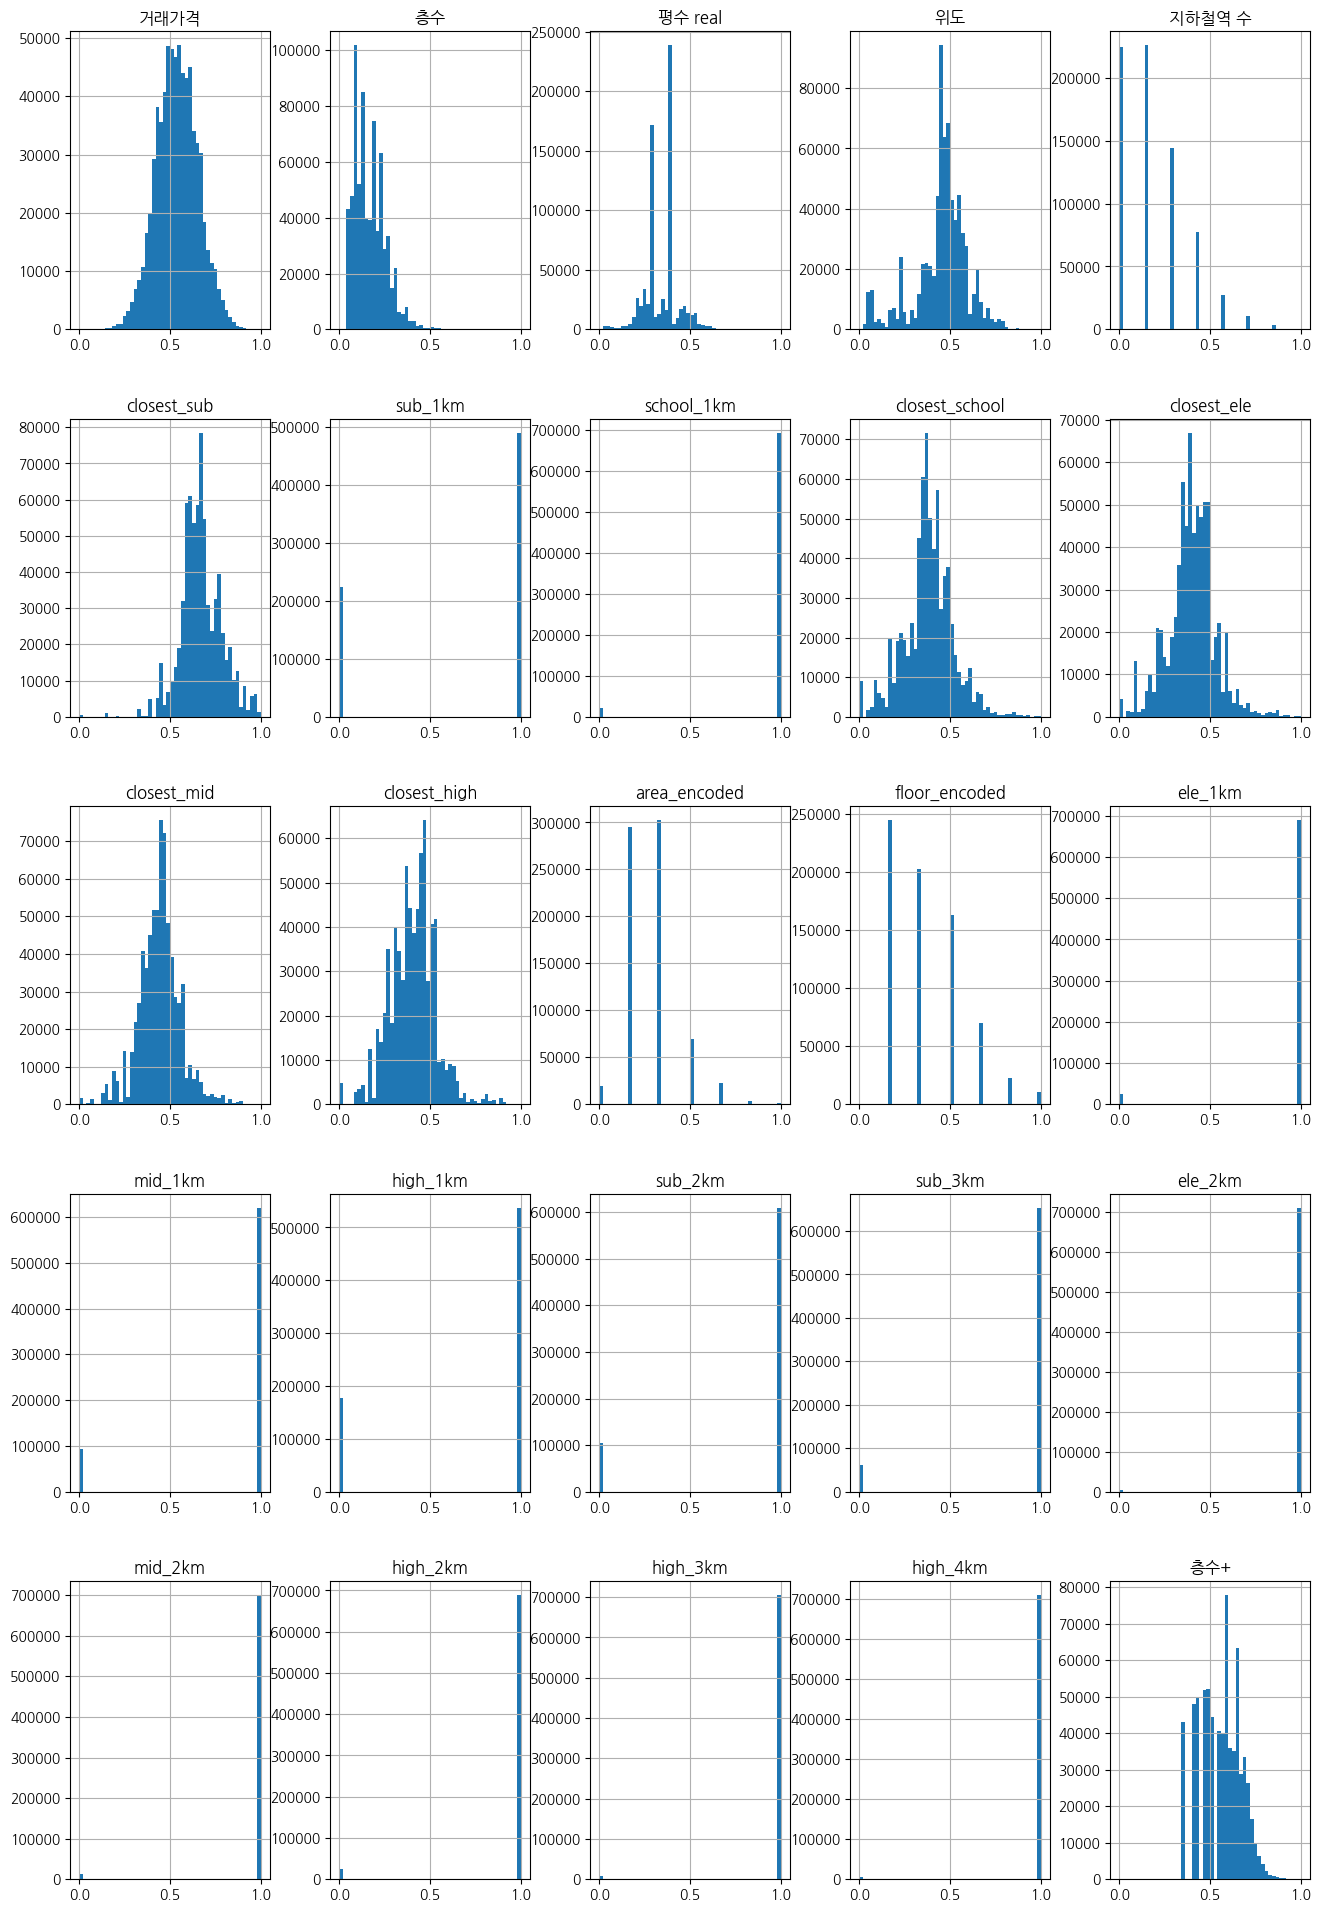

In [157]:
scaled_features_df3.hist(bins=50, figsize=(16, 24))
plt.rc('font', family='NanumGothic')

In [27]:
#%matplotlib inline
#plt.rc('font', family='NanumGothic')
#scaled_features_df.hist(bins=50, figsize=(20, 15))

In [28]:
#plt.scatter(scaled_features_df['층수'], scaled_features_df['거래가격'], label='층수')
#plt.scatter(scaled_features_df['지하철역 수'], scaled_features_df['거래가격'], label='지하철역 수')
#plt.scatter(scaled_features_df['학교 수'], scaled_features_df['거래가격'], label='학교 수')
#plt.scatter(scaled_features_df['area_encoded'], scaled_features_df['거래가격'], label='평형')
#plt.scatter(scaled_features_df['floor_encoded'], scaled_features_df['거래가격'], label='층수')

# add legend, axis labels, and title
#plt.legend()
#plt.xlabel('')
#plt.ylabel('거래가격')
#plt.title('거래가격 상관관계')
#plt.rc('font', family='NanumGothic')
#plt.show()

array([0.36109844, 0.14540591, 0.10357365, 0.08038443, 0.07081576])

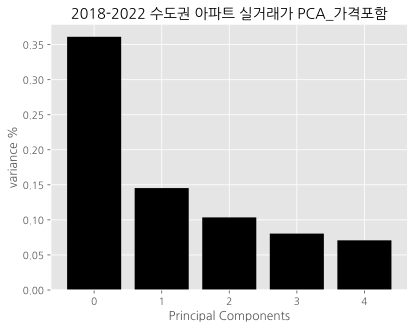

In [162]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

plt.style.use('ggplot')

#Create a PCA instance
pca=PCA(n_components=5)
principalComponents=pca.fit_transform(scaled_features3)
#Plot the expained variaces
features=range(pca.n_components_)
plt.bar(features,pca.explained_variance_ratio_,color='black')
plt.xlabel("Principal Components")
plt.ylabel('variance %')
plt.title('2018-2022 수도권 아파트 실거래가 PCA_가격포함')
plt.savefig('2018-2022 수도권 아파트 실거래가 PCA_거래가격포함_정규화후MinMax.png')
plt.rc('font', family='NanumGothic')
plt.xticks(features)

#Save components to a dataframe
PCA_components=pd.DataFrame(principalComponents)

#Show the expained variance by each principal component
pca.explained_variance_ratio_

In [164]:
#Plot scatter plot
agc = AgglomerativeClustering(n_clusters = 6)
plt.figure(figsize =(6, 4))
plt.scatter(PCA_components[0],PCA_components[1], c = agc.fit_predict(PCA_components), cmap ='rainbow')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2018-2022 수도권 아파트 실거래가 k=6 PC1-PC2 클러스터링_가격포함", fontsize=15)
plt.savefig('2018-2022 수도권 아파트 실거래가 k=6 PC1-PC2 클러스터링_거래가격포함_정규화후MinMax.png')
plt.rc('font', family='NanumGothic')
plt.rc("axes", unicode_minus = False)
plt.show()

MemoryError: Unable to allocate 1.85 TiB for an array with shape (254624968153,) and data type float64

<Figure size 600x400 with 0 Axes>

In [165]:
weights = pca.components_
weights_df = pd.DataFrame(weights, columns=scaled_features_df3.columns)
weights_df

ValueError: Shape of passed values is (5, 38), indices imply (5, 25)

/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/subin/다운로드/venv/li

<function matplotlib.pyplot.show(close=None, block=None)>

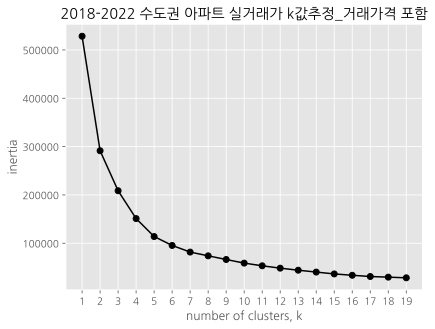

In [167]:
ks=range(1,20)
inertias=[]
for k in ks:
    model=KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:3]) #we only use the first 3 principal components
    inertias.append(model.inertia_)
    
plt.plot(ks,inertias, '-o',color='black')    
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title('2018-2022 수도권 아파트 실거래가 k값추정_거래가격 포함')
plt.xticks(ks)
plt.show

In [32]:
#Plot scatter plot
#agc = AgglomerativeClustering(n_clusters = 7)
#plt.figure(figsize =(6, 4))
#plt.scatter(PCA_components[0],PCA_components[1], c = agc.fit_predict(PCA_components), cmap ='rainbow')
#plt.xlabel("PC1")
#plt.ylabel("PC2")
#plt.title("2018-2022 서울 아파트 실거래가 k=5 PC1-PC2 클러스터링_거래가격포함", fontsize=15)
#plt.rc('font', family='NanumGothic')
#plt.rc("axes", unicode_minus = False)
#plt.show()

In [33]:
PCA_components

,0,1,2,3,4
0,0.139977,0.201957,-0.419841,0.018111,-0.229544
1,0.140142,0.202518,-0.419782,0.018172,-0.229209
2,0.140803,0.204763,-0.419547,0.018415,-0.227870
3,0.140638,0.204202,-0.419606,0.018355,-0.228205
4,0.137630,0.193988,-0.420678,0.017247,-0.234298
...,...,...,...,...,...
249109,0.361064,-0.214178,-0.109999,0.162543,-0.184839
249110,0.280255,-0.087410,0.088098,0.096750,0.069543
249111,0.279320,0.166656,-0.128036,0.036604,-0.037701
249112,0.291169,-0.008392,-0.108221,0.207811,-0.139623


In [34]:
PCA_components_sizedown = PCA_components.astype('float32')

In [35]:
#plot 3-D scatter plot
#%matplotlib widget
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)
#from matplotlib.pyplot import pyplot
#from mpl_toolkits.mplot3d import Axes3D
#kmeans=KMeans(n_clusters=5,  init='k-means++',random_state=42)
#kmeans.fit(PCA_components.iloc[:,:3])
#labels=kmeans.predict(PCA_components.iloc[:,:3])

#fig = plt.figure()

#ax = Axes3D(fig)
#ax.scatter(PCA_components[0],PCA_components[1],PCA_components[2],c=labels)
#plt.show()


In [168]:
%matplotlib widget
kmeans = KMeans(n_clusters=5)

# Fit the KMeans object to the seocho2
kmeans.fit(scaled_features_df3)

# Get the labels for each seocho2 point
labels = kmeans.predict(scaled_features_df3)

/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
print(labels)

[1 1 1 ... 0 0 4]


In [40]:
#filter rows of original data
#filtered_label0 = scaled_features_df[labels == 0]
 
#plotting the results
#plt.scatter(filtered_label0[:,3] , filtered_label0[:,0])
#plt.show()

In [180]:
scaled_features_df3.drop('층수', axis=1, inplace=True)

In [189]:
scaled_features_df4.drop(['층수', 'school_4km', 'ele_4km', 'school_5km', 'ele_5km', 'mid_3km', 'high_5km', 'school_2km', 'mid_4km'], axis=1, inplace=True)
scaled_features_df4.drop(['ele_3km', 'school_3km', 'mid_5km', 'scaled_floor'], axis=1, inplace=True)

In [191]:
kmeans = KMeans(n_clusters=5)
scaled_features_df3["Cluster"] = kmeans.fit_predict(scaled_features_df4)
scaled_features_df3["Cluster"] = scaled_features_df3["Cluster"].astype("int")
print(scaled_features_df3.head())

/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


       거래가격   평수 real        위도        경도    지하철역 수  closest_sub  sub_1km  \
0  0.340035  0.298811  0.707582  0.818216  0.142857     0.696131      1.0   
1  0.340035  0.298811  0.707582  0.818216  0.142857     0.696131      1.0   
2  0.343286  0.295064  0.707582  0.818216  0.142857     0.696131      1.0   
3  0.320864  0.342834  0.707582  0.818216  0.142857     0.696131      1.0   
4  0.414429  0.389144  0.707582  0.818216  0.142857     0.696131      1.0   

   school_1km  closest_school  closest_ele  closest_mid  closest_high  \
0         0.0        0.657927     0.915821     0.713882      0.483806   
1         0.0        0.657927     0.915821     0.713882      0.483806   
2         0.0        0.657927     0.915821     0.713882      0.483806   
3         0.0        0.657927     0.915821     0.713882      0.483806   
4         0.0        0.657927     0.915821     0.713882      0.483806   

   area_encoded  floor_encoded  ele_1km  mid_1km  high_1km  sub_2km  sub_3km  \
0      0.166667   

In [51]:
kmeans = KMeans(n_clusters=6)
seoul_withPrice["Cluster"] = kmeans.fit_predict(seoul_withPrice)
seoul_withPrice["Cluster"] = seoul_withPrice["Cluster"].astype("int")
print(seoul_withPrice.head())

/home/subin/다운로드/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              거래가격        위도          경도  지하철역 수  학교 수 area_encoded  \
732746  1950000000  37.47826  127.052024     0.0     7            2   
732747  2000000000  37.47826  127.052024     0.0     7            2   
732748  2200000000  37.47826  127.052024     0.0     7            2   
732749  2150000000  37.47826  127.052024     0.0     7            2   
732750  1240000000  37.47826  127.052024     0.0     7            2   

       floor_encoded  Cluster  
732746             1        1  
732747             1        1  
732748             1        1  
732749             1        1  
732750             1        5  


/tmp/ipykernel_9942/1689647045.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


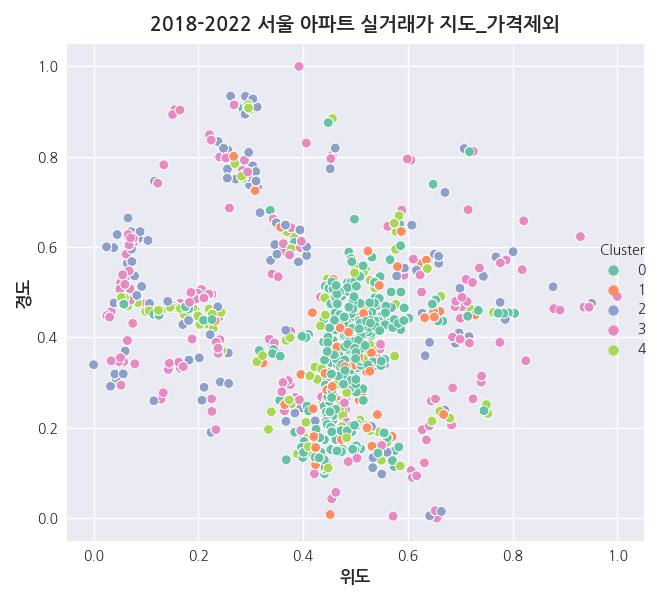

In [192]:
plt.style.use("seaborn")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight='bold', labelsize='large', titleweight='bold', titlesize=14, titlepad=10)
plt.rc('font', family = 'NanumGothic')


sns.relplot(x="위도", y="경도", hue="Cluster", data=scaled_features_df3, height=6, palette="Set2").set(title='2018-2022 서울 아파트 실거래가 지도_가격제외')
plt.savefig('2018-2022 수도권 아파트 실거래가 k=5 clustering 지도_거래가격제외_정규화후MinMax.png')
plt.show()

In [85]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
scaled_features_df3 = scaled_features_df.drop('Cluster', axis=1)
#scaled_features_df3[['거래가격', '지하철역 수', 'area_encoded', 'floor_encoded']] = pd.DataFrame(pt.fit_transform(scaled_features_df3[['거래가격', '지하철역 수', 'area_encoded', 'floor_encoded']]), columns=['거래가격', '지하철역 수', 'area_encoded', 'floor_encoded'])

scaled_features_df3['floor_encoded'] = pd.DataFrame(pt.fit_transform(scaled_features_df3['floor_encoded']), columns='floor_encoded')

scaled_features_df3.hist()

ValueError: Expected 2D array, got 1D array instead:
array=[-1.21442411 -1.21442411 -1.21442411 ...  0.01000894 -1.21442411
  2.14788495].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

array([[<Axes: title={'center': '거래가격'}>, <Axes: title={'center': '위도'}>,
        <Axes: title={'center': '경도'}>],
       [<Axes: title={'center': '지하철역 수'}>,
        <Axes: title={'center': '학교 수'}>,
        <Axes: title={'center': 'area_encoded'}>],
       [<Axes: title={'center': 'floor_encoded'}>, <Axes: >, <Axes: >]],
      dtype=object)

/home/subin/다운로드/venv/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


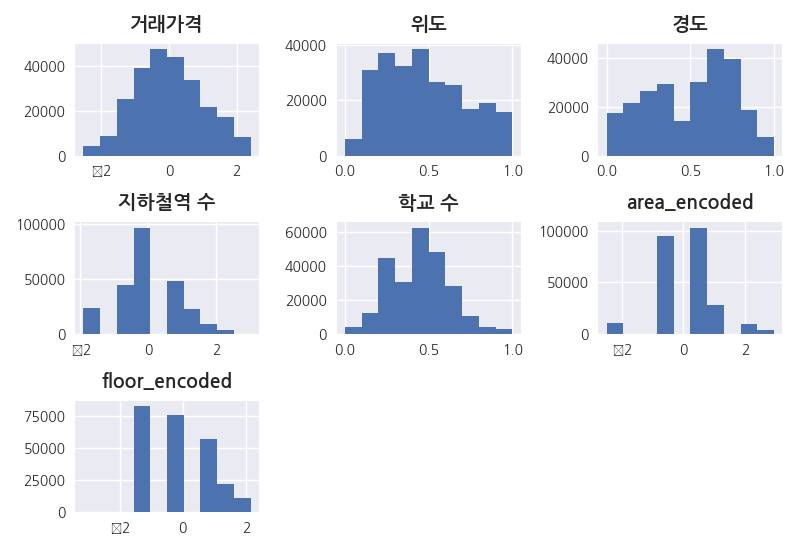

In [86]:

scaled_features_df3.hist()